In this case, we had masks created with cellpose. The masks were divided in two types: one type contained individual organelles. The other mask contain the cells (each cell can have up to 6 organelles). In this notebook, we're selecting only the masks with invidual organelles. Sometimes, in other notebooks, we use the cell mask to cut the set of organelles per cell. 

In [ ]:
# Import required packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
%matplotlib inline
import gdown
from skimage.measure import label, regionprops, regionprops_table
from scipy.stats import gaussian_kde
import torch

In [ ]:
#Importing cellpose
!pip install cellpose==0.6.2

     |████████████████████████████████| 13.3 MB 7.8 MB/s 
     |████████████████████████████████| 37.1 MB 81 kB/s 
  Created wheel for cellpose: filename=cellpose-0.6.2-py3-none-any.whl size=149342 sha256=555604a62f364209bdc3d6e96f333c07c4d1d45f7418f40f63442bb25771af9d
  Stored in directory: /root/.cache/pip/wheels/9e/f8/87/6ecd94d1a14441484e168da8761f8a76c5f2b86a41af20cfb5
Successfully built cellpose


In [ ]:
from cellpose import models, utils,plot,io

100%|██████████| 25.2M/25.2M [00:01<00:00, 24.6MB/s]
100%|██████████| 25.2M/25.2M [00:01<00:00, 22.0MB/s]
100%|██████████| 25.2M/25.2M [00:00<00:00, 26.6MB/s]
100%|██████████| 25.2M/25.2M [00:01<00:00, 21.8MB/s]
100%|██████████| 3.55k/3.55k [00:00<00:00, 8.63MB/s]
100%|██████████| 25.3M/25.3M [00:01<00:00, 24.6MB/s]
100%|██████████| 25.3M/25.3M [00:01<00:00, 25.3MB/s]
100%|██████████| 25.3M/25.3M [00:01<00:00, 24.7MB/s]
100%|██████████| 25.3M/25.3M [00:01<00:00, 25.4MB/s]
100%|██████████| 5.23k/5.23k [00:00<00:00, 8.21MB/s]
100%|██████████| 25.2M/25.2M [00:01<00:00, 23.7MB/s]
100%|██████████| 25.2M/25.2M [00:01<00:00, 26.1MB/s]
100%|██████████| 25.2M/25.2M [00:01<00:00, 26.0MB/s]
100%|██████████| 25.2M/25.2M [00:01<00:00, 23.4MB/s]
100%|██████████| 3.55k/3.55k [00:00<00:00, 8.21MB/s]
100%|██████████| 25.3M/25.3M [00:01<00:00, 25.4MB/s]
100%|██████████| 25.3M/25.3M [00:01<00:00, 23.8MB/s]
100%|██████████| 25.3M/25.3M [00:01<00:00, 25.1MB/s]
100%|██████████| 25.3M/25.3M [00:00<00:00, 27.

In [ ]:
#Checking that cellpose is using GPUs
use_GPU = models.use_gpu()
print('>>> GPU activated? %d'%use_GPU)
model = models.Cellpose(gpu=use_GPU, model_type='cyto')

>>> GPU activated? 1


In [ ]:
# Some helper functions to cut windows of the same size and containing only invididual organelles.
def make_square(img,box_size):
  y = (box_size - img.shape[0])
  if y%2==0:
    y1=y2=y/2
  else:
    y1 = np.ceil(y/2)
    y2 = y - y1
  x = (box_size - img.shape[1])
  if x%2==0:
    x1=x2=x/2
  else:
    x1 = np.ceil(x/2)
    x2 = x - x1
  
  return np.pad(img,((int(y1),int(y2)),(int(x1),int(x2))),mode='constant',constant_values=0)
  
def normalize_01(inp: np.ndarray):
    """
    normalize image range from 0 to 1
    """
    inp_out = (inp - np.min(inp)) / np.ptp(inp)
    return inp_out

def rotate_and_pad_img(sample,pixels,box_size,rotate=False):
    """
    Function to crop, rotate, and pad a labelled section of a segmented image
    Args:
      sample (label)
      Sample from labelled image

      pixels (array)
      image array, H x W, single-channel
      
      box_size (int)
      Size of final square image dimension
    Returns square-padded image array
    """
    angle = np.degrees(sample.orientation)
    length = sample.major_axis_length
    width = sample.minor_axis_length
    target_channel = pixels[sample.slice[0].start:sample.slice[0].stop, sample.slice[1].start:sample.slice[1].stop]
    target_channel = target_channel * sample.filled_image
    if rotate == True:
      rotated_image = sk.transform.rotate(target_channel, -angle-90, resize = True)
      H, W = rotated_image.shape
      image_center = rotated_image[max([int(H/2-width/2), 0]):int(H/2+width/2)+1,max([0,int(W/2-length/2)]):int(W/2+length/2)]
      return make_square(normalize_01(image_center),box_size)
    else:
      return make_square(normalize_01(target_channel),box_size)

def mask2stack(ccm_mask,cell_mask=None,window_size=40,rotate=False):
  """
  Function to ingest cell mask and carboxysome mask or pixel intensity and output an array of padded submasks
  Args:
  cell_mask (labelled image)
  
  ccm_mask (labelled image or pixel intensity array)

  window_size (int)
  Size of padded image
  """

  if cell_mask:
    labelled_image = label(cell_mask)
    feature_table = regionprops(labelled_image)
    CellSize_label = []
        # remove debris
    for i in feature_table:
        if (i.area) > 40 and (i.major_axis_length/i.minor_axis_length) > 2:
                CellSize_label.append(i.label)
    subimgs = []
    for i in np.argsort(CellSize_label):
        sample = feature_table[CellSize_label[i]-1]
        cell = rotate_and_pad_img(sample,cell_mask,window_size,rotate)
        ccm = rotate_and_pad_img(sample,ccm_mask,window_size,rotate)
        #ccm = np.ones(ccm.shape) * (ccm >0.01)
        subimgs.append(ccm)
  else:
    labelled_image = label(ccm_mask)
    feature_table = regionprops(labelled_image)
    subimgs = [make_square(np.ones(sample.filled_image.shape) * sample.filled_image,window_size) for sample in feature_table]
  return np.stack(subimgs,axis=0)

In [ ]:
#Downloading the masks for the individual organelles
#Control
!gdown "https://drive.google.com/uc?id=1LjDx5KsyAmeU_dsCBKtm9owwn8K-LH4D"
!gdown "https://drive.google.com/uc?id=1EYINPg4TJ-go9YngqzqJgcA-nARvSrC5"
!gdown "https://drive.google.com/uc?id=1ynMY28tFKObJONj_VlYmJSz66RDgpJXC"
!gdown "https://drive.google.com/uc?id=1fEXfxdKyHOdNoR0ECyMeWpH8gpQKNKl8"
!gdown "https://drive.google.com/uc?id=1vcyubNGZGp7k4Ikf7n47LNHuzh0USPuD"
#Induced
!gdown "https://drive.google.com/uc?id=1HUvCPFggJ2eP2hoSyu-5BZvhd5qUuZ53"
!gdown "https://drive.google.com/uc?id=1fxWEXUmw3olEj3nplcjC5D982DTj0xJE"
!gdown "https://drive.google.com/uc?id=1QoQRaW5WN3oxqK1WeNXxI0gCB472vVbI"
!gdown "https://drive.google.com/uc?id=12H57Tr3AGshvQMqtWfN5ZzzkJsQx5_aj"
!gdown "https://drive.google.com/uc?id=1EkCDSs3zI9ly0Fd2cmt7LcLbmQlFXMmx"


Downloading...
From: https://drive.google.com/uc?id=1LjDx5KsyAmeU_dsCBKtm9owwn8K-LH4D
To: /content/control4_gfp_masks.npy
113MB [00:00, 131MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EYINPg4TJ-go9YngqzqJgcA-nARvSrC5
To: /content/control8_gfp_masks.npy
113MB [00:00, 139MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1ynMY28tFKObJONj_VlYmJSz66RDgpJXC
To: /content/control24_gfp_masks.npy
102MB [00:00, 125MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1fEXfxdKyHOdNoR0ECyMeWpH8gpQKNKl8
To: /content/control48_gfp_masks.npy
45.2MB [00:00, 171MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vcyubNGZGp7k4Ikf7n47LNHuzh0USPuD
To: /content/control72_gfp_masks.npy
102MB [00:00, 219MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1HUvCPFggJ2eP2hoSyu-5BZvhd5qUuZ53
To: /content/induced4_gfp_masks.npy
113MB [00:00, 139MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1fxWEXUmw3olEj3nplcjC5D982DTj0xJE
To: /content/induced8_gfp_masks.npy


In [ ]:
array_gfp_masks = np.load('control4_gfp_masks.npy')
# array_dsred_masks = np.load('control72_dsred_masks.npy') #This is the cell mask. Not used in this notebook
# array_dsred_masks.shape, 
print(array_gfp_masks.shape)
n = len(array_gfp_masks[:,0,0])
carboxysome_stack = []

for i in range(n):
  carboxysome_stack.append(mask2stack(array_gfp_masks[i],rotate=False))

subimg_1 = np.vstack(carboxysome_stack[i] for i in range(n))
print(subimg_1.shape)

(10, 1460, 1936)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


(40619, 40, 40)


In [ ]:
array_gfp_masks = np.load('control8_gfp_masks.npy')
# array_dsred_masks = np.load('control72_dsred_masks.npy') #This is the cell mask. Not used in this notebook
# array_dsred_masks.shape, 
print(array_gfp_masks.shape)
n = len(array_gfp_masks[:,0,0])
carboxysome_stack = []

for i in range(n):
  carboxysome_stack.append(mask2stack(array_gfp_masks[i],rotate=False))

subimg_2 = np.vstack(carboxysome_stack[i] for i in range(n))
print(subimg_2.shape)

(10, 1460, 1936)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


(53053, 40, 40)


In [ ]:
array_gfp_masks = np.load('control24_gfp_masks.npy')
# array_dsred_masks = np.load('control72_dsred_masks.npy') #This is the cell mask. Not used in this notebook
# array_dsred_masks.shape, 
print(array_gfp_masks.shape)
n = len(array_gfp_masks[:,0,0])
carboxysome_stack = []

for i in range(n):
  carboxysome_stack.append(mask2stack(array_gfp_masks[i],rotate=False))

subimg_3 = np.vstack(carboxysome_stack[i] for i in range(n))
print(subimg_3.shape)

(9, 1460, 1936)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


(49713, 40, 40)


In [ ]:
array_gfp_masks = np.load('control48_gfp_masks.npy')
# array_dsred_masks = np.load('control72_dsred_masks.npy') #This is the cell mask. Not used in this notebook
# array_dsred_masks.shape, 
print(array_gfp_masks.shape)
n = len(array_gfp_masks[:,0,0])
carboxysome_stack = []

for i in range(n):
  carboxysome_stack.append(mask2stack(array_gfp_masks[i],rotate=False))

subimg_4 = np.vstack(carboxysome_stack[i] for i in range(n))
print(subimg_4.shape)

(4, 1460, 1936)
(23255, 40, 40)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
array_gfp_masks = np.load('control72_gfp_masks.npy')
# array_dsred_masks = np.load('control72_dsred_masks.npy') #This is the cell mask. Not used in this notebook
# array_dsred_masks.shape, 
print(array_gfp_masks.shape)
n = len(array_gfp_masks[:,0,0])
carboxysome_stack = []

for i in range(n):
  carboxysome_stack.append(mask2stack(array_gfp_masks[i],rotate=False))

subimg_5 = np.vstack(carboxysome_stack[i] for i in range(n))
print(subimg_5.shape)

(9, 1460, 1936)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


(40378, 40, 40)


In [ ]:
array_gfp_masks = np.load('induced4_gfp_masks.npy')
# array_dsred_masks = np.load('control72_dsred_masks.npy') #This is the cell mask. Not used in this notebook
# array_dsred_masks.shape, 
print(array_gfp_masks.shape)
n = len(array_gfp_masks[:,0,0])
carboxysome_stack = []

for i in range(n):
  carboxysome_stack.append(mask2stack(array_gfp_masks[i],rotate=False))

subimg_6 = np.vstack(carboxysome_stack[i] for i in range(n))
print(subimg_6.shape)

(10, 1460, 1936)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


(42101, 40, 40)


In [ ]:
array_gfp_masks = np.load('induced8_gfp_masks.npy')
# array_dsred_masks = np.load('control72_dsred_masks.npy') #This is the cell mask. Not used in this notebook
# array_dsred_masks.shape, 
print(array_gfp_masks.shape)
n = len(array_gfp_masks[:,0,0])
carboxysome_stack = []

for i in range(n):
  carboxysome_stack.append(mask2stack(array_gfp_masks[i],rotate=False))

subimg_7 = np.vstack(carboxysome_stack[i] for i in range(n))
print(subimg_7.shape)

(6, 1460, 1936)
(2756, 40, 40)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
array_gfp_masks = np.load('induced24_gfp_masks.npy')
# array_dsred_masks = np.load('control72_dsred_masks.npy') #This is the cell mask. Not used in this notebook
# array_dsred_masks.shape, 
print(array_gfp_masks.shape)
n = len(array_gfp_masks[:,0,0])
carboxysome_stack = []

for i in range(n):
  carboxysome_stack.append(mask2stack(array_gfp_masks[i],rotate=False))

subimg_8 = np.vstack(carboxysome_stack[i] for i in range(n))
print(subimg_8.shape)

(9, 1460, 1936)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


(41867, 40, 40)


In [ ]:
array_gfp_masks = np.load('induced48_gfp_masks.npy')
# array_dsred_masks = np.load('control72_dsred_masks.npy') #This is the cell mask. Not used in this notebook
# array_dsred_masks.shape, 
print(array_gfp_masks.shape)
n = len(array_gfp_masks[:,0,0])
carboxysome_stack = []

for i in range(n):
  carboxysome_stack.append(mask2stack(array_gfp_masks[i],rotate=False))

subimg_9 = np.vstack(carboxysome_stack[i] for i in range(n))
print(subimg_9.shape)

(5, 1460, 1936)
(20408, 40, 40)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
array_gfp_masks = np.load('induced72_gfp_masks.npy')
# array_dsred_masks = np.load('control72_dsred_masks.npy') #This is the cell mask. Not used in this notebook
# array_dsred_masks.shape, 
print(array_gfp_masks.shape)
n = len(array_gfp_masks[:,0,0])
carboxysome_stack = []

for i in range(n):
  carboxysome_stack.append(mask2stack(array_gfp_masks[i],rotate=False))

subimg_10 = np.vstack(carboxysome_stack[i] for i in range(n))
print(subimg_10.shape)

(9, 1460, 1936)
(13650, 40, 40)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
subimg =  np.vstack((subimg_1,subimg_2,subimg_3,subimg_4,subimg_5,subimg_6,subimg_7,subimg_8,subimg_9,subimg_10))

In [ ]:
subimg.shape

(327800, 40, 40)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
# np.save('indiv-CB-masks-control-and-induced.npy',subimg)

**Plotting some of the subimages**

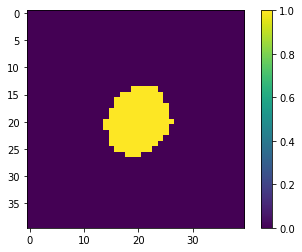

In [ ]:
plt.imshow(subimg[3000,:,:])
plt.colorbar()

In [ ]:
pip install atomai

     |████████████████████████████████| 143 kB 7.9 MB/s 
     |████████████████████████████████| 498 kB 41.9 MB/s 
     |████████████████████████████████| 193 kB 48.5 MB/s 
     |████████████████████████████████| 865 kB 35.0 MB/s 
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl size=174982 sha256=13a94002b788077dfc4d4e6713c90632c3a893c00c79276d453da03ae00a4fac
  Stored in directory: /root/.cache/pip/wheels/f4/4e/dd/06777c90710ce1766376ecc87979967fe69ff3affc29c0b530
Successfully built mendeleev


In [ ]:
import atomai as aoi

**rVAE**

In [ ]:
!gdown "https://drive.google.com/uc?id=1-Ce5eqdRXITvMTlotMcKNwv2xWEr-fz0"

window_size = 40
in_dim = (window_size, window_size)

rvae= aoi.models.load_model("rvae-iter100-control-and-induced-4-8-24-48-72.tar")


# rvae = aoi.models.rVAE(in_dim, translation= True,
#                        numlayers_encoder=3, numhidden_encoder=128,
#                        numlayers_decoder=3, numhidden_decoder=128,
#                        Skip = True)

rvae.fit(subimg, training_cycles =    1)

Downloading...
From: https://drive.google.com/uc?id=1-Ce5eqdRXITvMTlotMcKNwv2xWEr-fz0
To: /content/rvae-iter100-control-and-induced-4-8-24-48-72.tar
3.50MB [00:00, 110MB/s]
Epoch: 1/1, Training loss: 8.7524


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
# rvae.save_model("rvae-iter100-control-and-induced-4-8-24-48-72")
# rvae.save_weights("w-rvae-iter100-control-and-induced-4-8-24-48-72")

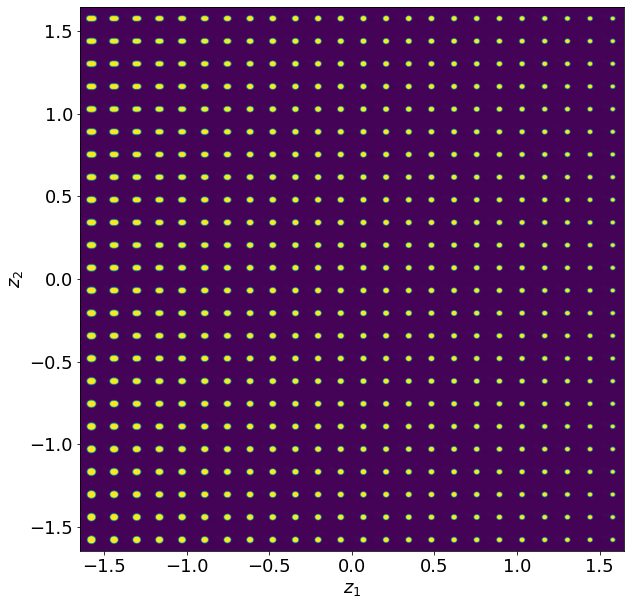

In [ ]:
rvae.manifold2d(d=24, cmap="viridis");


In [ ]:
# rvae.manifold2d(d=5,l1=[-1.5,-1],l2=[-1.5,-1],cmap='viridis');

In [ ]:
# rvae.manifold2d(d=5,l1=[0,0.5],l2=[0,0.5],cmap='viridis');

In [ ]:
#Control
a4c, b4c = rvae.encode(subimg_1)
a8c, b8c = rvae.encode(subimg_2)
a24c, b24c = rvae.encode(subimg_3)
a48c, b48c = rvae.encode(subimg_4)
a72c, b72c = rvae.encode(subimg_5)
#Induced
a4i, b4i = rvae.encode(subimg_6)
a8i, b8i = rvae.encode(subimg_7)
a24i, b24i = rvae.encode(subimg_8)
a48i, b48i = rvae.encode(subimg_9)
a72i, b72i = rvae.encode(subimg_10)

0.0 0.0
0.0 1.0
0.0 2.0
0.0 3.0
0.0 4.0


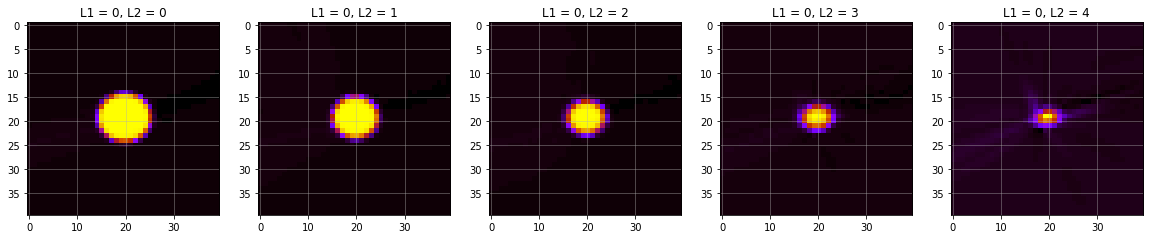

In [ ]:
# Example of size variation

# L1 = 0
# L2 = 0
lv1_vals = np.linspace(0,1,1)
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = 0 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded1 = rvae.decode(lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L1 = 0
# L2 = 1
lv1_vals = np.linspace(0,1,1)
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = 1 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded2 = rvae.decode(lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L1 = 0
# L2 = 2
lv1_vals = np.linspace(0,1,1)
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = 2 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded3 = rvae.decode(lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L1 = 0
# L2 = 3
lv1_vals = np.linspace(0,1,1)
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = 3 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded4 = rvae.decode(lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L1 = 0
# L2 = 4
lv1_vals = np.linspace(0,1,1)
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = 4 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded5 = rvae.decode(lv_vals)
print(lv1_vals[0],lv2_vals[0])

# # L1 = 1.7
# # L2 = 2
# lv1_vals = np.linspace(1.7,1.8,1)
# lv2_vals = np.zeros_like(lv1_vals)
# lv2_vals = 2 + lv2_vals
# lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
# decoded6 = rvae.decode(lv_vals)
# print(lv1_vals[0],lv2_vals[0])


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,5,1)
ax.imshow(decoded1[0], cmap="gnuplot")
ax.set_title('L1 = 0, L2 = 0')
# ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1,5,2)
ax.imshow(decoded2[0], cmap="gnuplot")
ax.set_title('L1 = 0, L2 = 1')
# ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1,5,3)
ax.imshow(decoded3[0], cmap="gnuplot")
ax.set_title('L1 = 0, L2 = 2')
# ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1,5,4)
ax.imshow(decoded4[0], cmap="gnuplot")
ax.set_title('L1 = 0, L2 = 3')
# ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1,5,5)
ax.imshow(decoded5[0], cmap="gnuplot")
ax.set_title('L1 = 0, L2 = 4')
# ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

# ax = fig.add_subplot(1,5,6)
# ax.imshow(decoded6[0], cmap="gnuplot")
# ax.set_title('L1 = 1.7, L2 = 2')
# # ax.set_xlim(0,35)
# ax.grid(alpha = 0.5)

-1.5 -2.0
-1.0 -2.0
0.0 -2.0
1.0 -2.0
1.0 -2.0


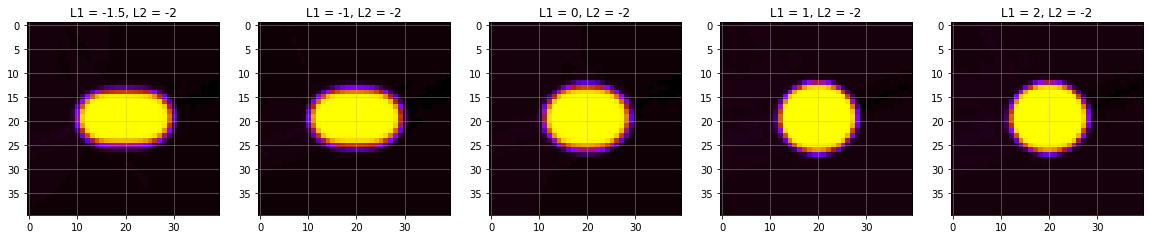

In [ ]:
# Example of shape variation

# L1 = 0
# L2 = 0
lv1_vals = np.linspace(-1.5,1,1)
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = -2 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded1 = rvae.decode(lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L1 = 0
# L2 = 1
lv1_vals = np.linspace(-1,1,1)
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = -2 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded2 = rvae.decode(lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L1 = 0
# L2 = 2
lv1_vals = np.linspace(0,1,1)
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = -2 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded3 = rvae.decode(lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L1 = 0
# L2 = 3
lv1_vals = np.linspace(1,2,1)
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = -2 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded4 = rvae.decode(lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L1 = 0
# L2 = 4
lv1_vals = np.linspace(1,3,1)
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = -2 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded5 = rvae.decode(lv_vals)
print(lv1_vals[0],lv2_vals[0])

# # L1 = 1.7
# # L2 = 2
# lv1_vals = np.linspace(1.7,1.8,1)
# lv2_vals = np.zeros_like(lv1_vals)
# lv2_vals = 2 + lv2_vals
# lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
# decoded6 = rvae.decode(lv_vals)
# print(lv1_vals[0],lv2_vals[0])


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,5,1)
ax.imshow(decoded1[0], cmap="gnuplot")
ax.set_title('L1 = -1.5, L2 = -2')
# ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1,5,2)
ax.imshow(decoded2[0], cmap="gnuplot")
ax.set_title('L1 = -1, L2 = -2')
# ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1,5,3)
ax.imshow(decoded3[0], cmap="gnuplot")
ax.set_title('L1 = 0, L2 = -2')
# ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1,5,4)
ax.imshow(decoded4[0], cmap="gnuplot")
ax.set_title('L1 = 1, L2 = -2')
# ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1,5,5)
ax.imshow(decoded5[0], cmap="gnuplot")
ax.set_title('L1 = 2, L2 = -2')
# ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

# ax = fig.add_subplot(1,5,6)
# ax.imshow(decoded6[0], cmap="gnuplot")
# ax.set_title('L1 = 1.7, L2 = 2')
# # ax.set_xlim(0,35)
# ax.grid(alpha = 0.5)

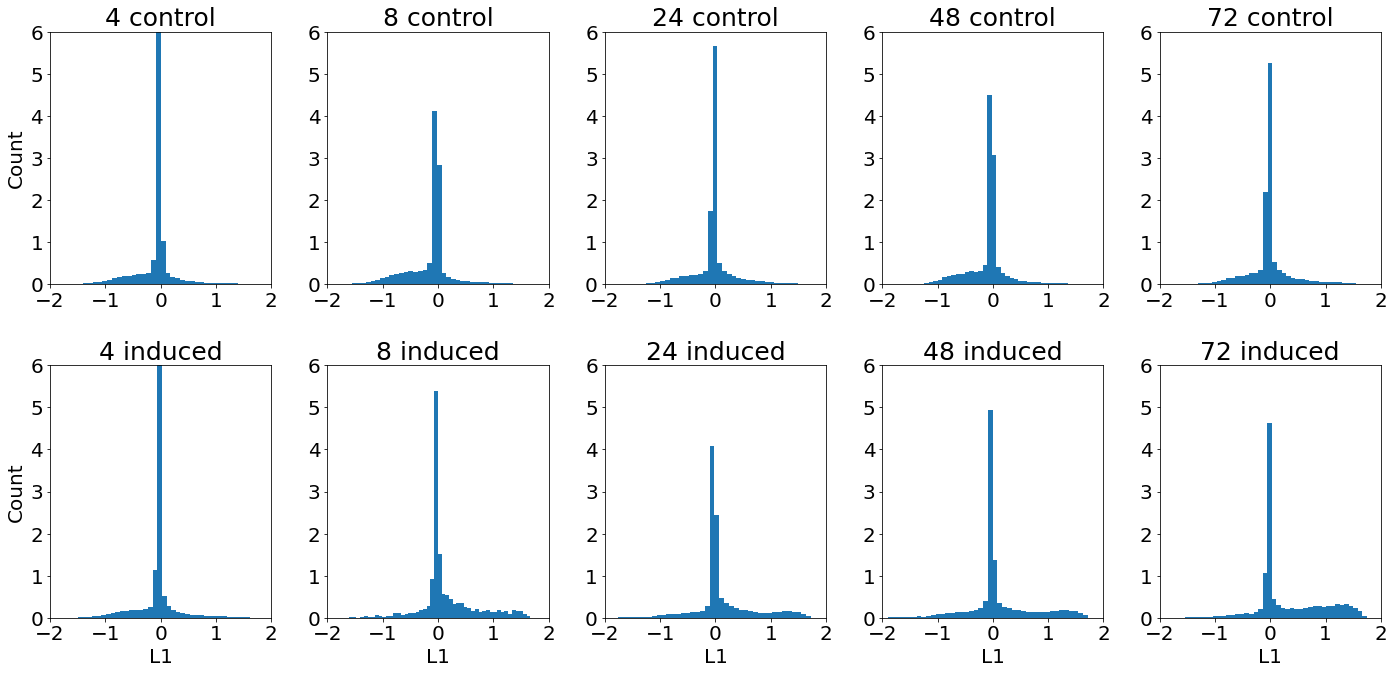

In [ ]:
#L1 histogram
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,5,1)
ax.set_title('4 control', fontsize=25) 
ax.hist(a4c[:,3], bins = 50, density = True, stacked = True);
# ax.set_xlabel('L1',fontsize=20)
ax.set_ylabel('Count',fontsize=20)
ax.set_xlim([-2, 2])
ax.set_ylim([0, 6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,2)
ax.set_title('8 control', fontsize=25) 
ax.hist(a8c[:,3], bins = 50, density = True, stacked = True);
# ax.set_xlabel('L1',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-2, 2])
ax.set_ylim([0, 6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,3)
ax.set_title('24 control',fontsize=25) 
ax.hist(a24c[:,3], bins = 50, density = True, stacked = True);
# ax.set_xlabel('L1',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-2, 2])
ax.set_ylim([0, 6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,4)
ax.set_title('48 control',fontsize=25) 
ax.hist(a48c[:,3], bins = 50, density = True, stacked = True);
# ax.set_xlabel('L1',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-2, 2])
ax.set_ylim([0, 6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,5)
ax.set_title('72 control',fontsize=25) 
ax.hist(a72c[:,3], bins = 50, density = True, stacked = True);
# ax.set_xlabel('L1',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-2, 2])
ax.set_ylim([0, 6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.tight_layout(pad=3.0)

#Induced
# fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,5,6)
ax.set_title('4 induced', fontsize=25) 
ax.hist(a4i[:,3], bins = 50, density = True, stacked = True);
ax.set_xlabel('L1',fontsize=20)
ax.set_ylabel('Count',fontsize=20)
ax.set_xlim([-2, 2])
ax.set_ylim([0, 6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,7)
ax.set_title('8 induced', fontsize=25) 
ax.hist(a8i[:,3], bins = 50, density = True, stacked = True);
ax.set_xlabel('L1',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-2, 2])
ax.set_ylim([0, 6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,8)
ax.set_title('24 induced',fontsize=25) 
ax.hist(a24i[:,3], bins = 50, density = True, stacked = True);
ax.set_xlabel('L1',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-2, 2])
ax.set_ylim([0, 6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,9)
ax.set_title('48 induced',fontsize=25) 
ax.hist(a48i[:,3], bins = 50, density = True, stacked = True);
ax.set_xlabel('L1',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-2, 2])
ax.set_ylim([0, 6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,10)
ax.set_title('72 induced',fontsize=25) 
ax.hist(a72i[:,3], bins = 50, density = True, stacked = True);
ax.set_xlabel('L1',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-2, 2])
ax.set_ylim([0, 6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.tight_layout(pad=3.0)

plt.savefig('all-HistogramL1')

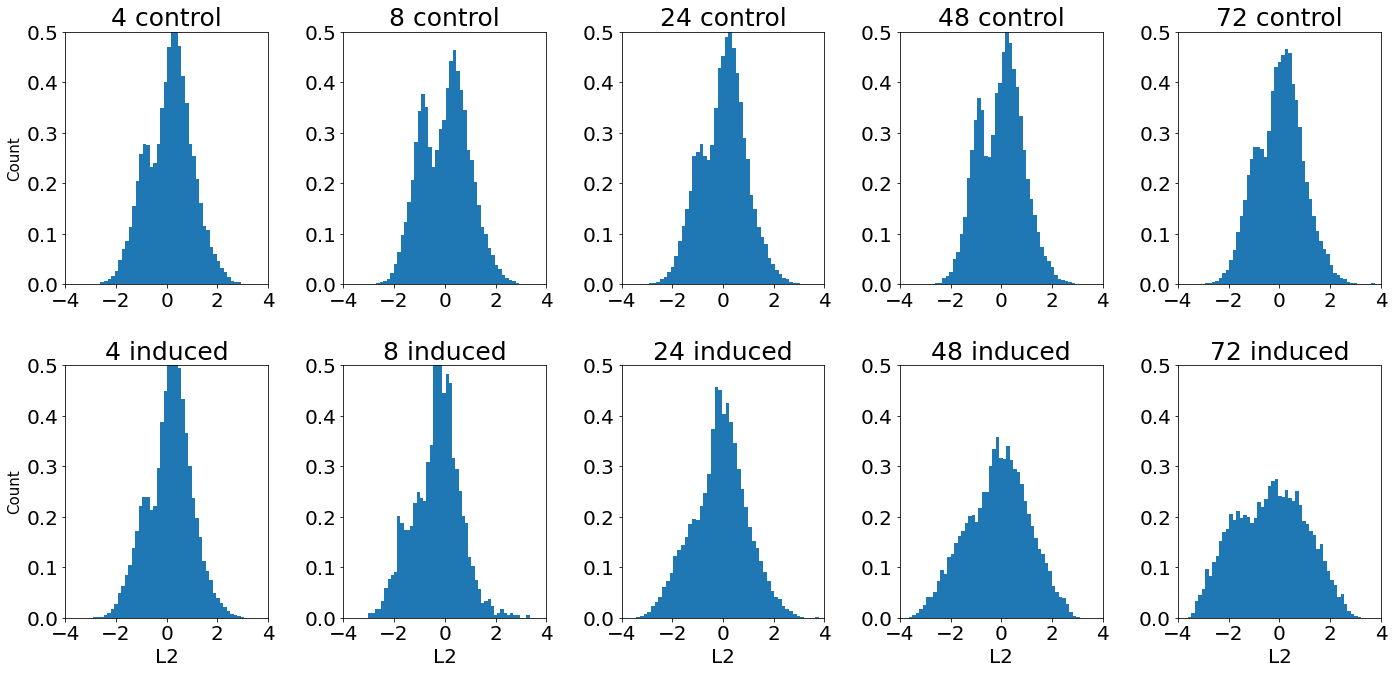

In [ ]:
#Control
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,5,1)
ax.set_title('4 control',fontsize=25) 
ax.hist(a4c[:,4], bins = 50, density = True, stacked = True);
# ax.set_xlabel('L2',fontsize=20)
ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, 0.5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,2)
ax.set_title('8 control',fontsize=25) 
ax.hist(a8c[:,4], bins = 50, density = True, stacked = True);
# ax.set_xlabel('L2',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, 0.5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,3)
ax.set_title('24 control',fontsize=25) 
ax.hist(a24c[:,4], bins = 50, density = True, stacked = True);
# ax.set_xlabel('L2',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, 0.5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,4)
ax.set_title('48 control',fontsize=25) 
ax.hist(a48c[:,4], bins = 50, density = True, stacked = True);
# ax.set_xlabel('L2',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, 0.5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,5)
ax.set_title('72 control',fontsize=25) 
ax.hist(a72c[:,4], bins = 50, density = True, stacked = True);
# ax.set_xlabel('L2',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, 0.5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.tight_layout(pad=3.0)

#Induced
# fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,5,6)
ax.set_title('4 induced',fontsize=25) 
ax.hist(a4i[:,4], bins = 50, density = True, stacked = True);
ax.set_xlabel('L2',fontsize=20)
ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, 0.5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,7)
ax.set_title('8 induced',fontsize=25) 
ax.hist(a8i[:,4], bins = 50, density = True, stacked = True);
ax.set_xlabel('L2',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, 0.5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,8)
ax.set_title('24 induced',fontsize=25) 
ax.hist(a24i[:,4], bins = 50, density = True, stacked = True);
ax.set_xlabel('L2',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, 0.5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,9)
ax.set_title('48 induced',fontsize=25) 
ax.hist(a48i[:,4], bins = 50, density = True, stacked = True);
ax.set_xlabel('L2',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, 0.5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,10)
ax.set_title('72 induced',fontsize=25) 
ax.hist(a72i[:,4], bins = 50, density = True, stacked = True);
ax.set_xlabel('L2',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, 0.5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.tight_layout(pad=3.0)

plt.savefig('all-HistogramL2')

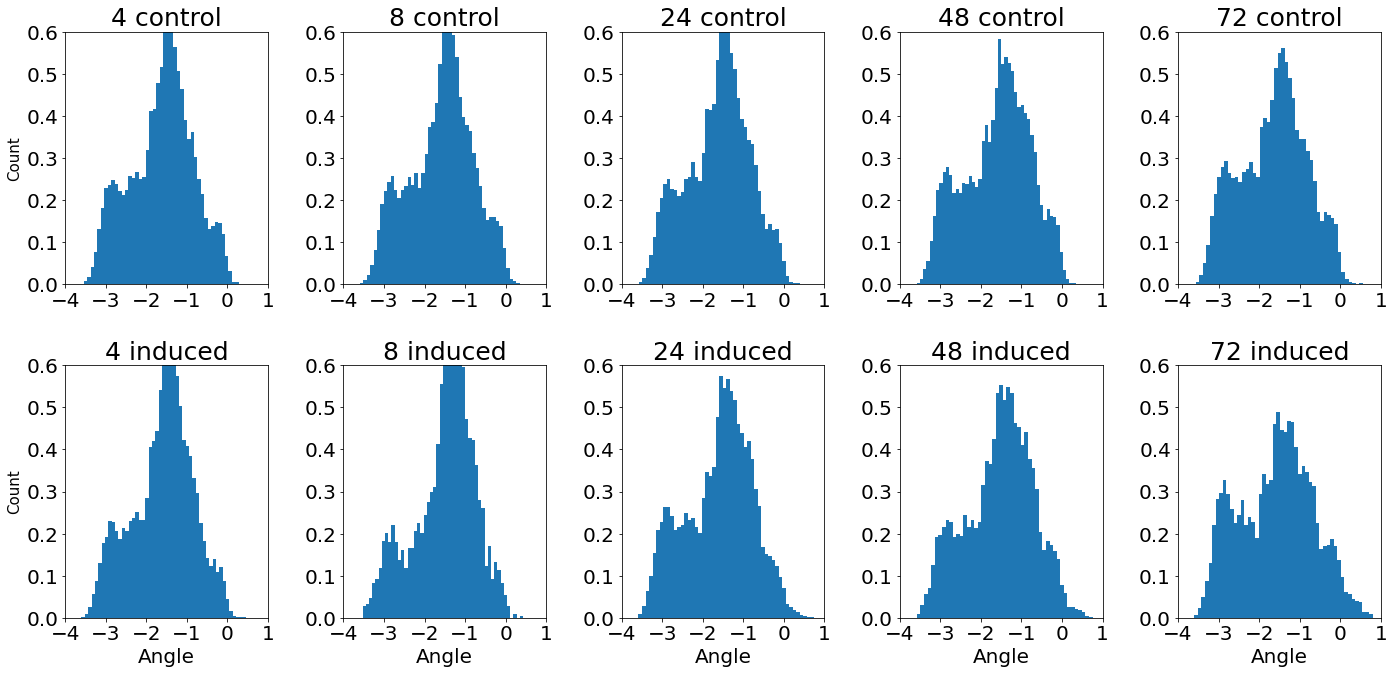

In [ ]:
#Control
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,5,1)
ax.set_title('4 control',fontsize=25) 
ax.hist(a4c[:,0], bins = 50, density = True, stacked = True);
# ax.set_xlabel('Angle',fontsize=20)
ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 1])
ax.set_ylim([0, 0.6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,2)
ax.set_title('8 control',fontsize=25) 
ax.hist(a8c[:,0], bins = 50, density = True, stacked = True);
# ax.set_xlabel('Angle',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 1])
ax.set_ylim([0, 0.6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,3)
ax.set_title('24 control',fontsize=25) 
ax.hist(a24c[:,0], bins = 50, density = True, stacked = True);
# ax.set_xlabel('Angle',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 1])
ax.set_ylim([0, 0.6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,4)
ax.set_title('48 control',fontsize=25) 
ax.hist(a48c[:,0], bins = 50, density = True, stacked = True);
# ax.set_xlabel('Angle',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 1])
ax.set_ylim([0, 0.6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,5)
ax.set_title('72 control',fontsize=25) 
ax.hist(a72c[:,0], bins = 50, density = True, stacked = True);
# ax.set_xlabel('Angle',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 1])
ax.set_ylim([0, 0.6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.tight_layout(pad=3.0)

#Induced
# fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,5,6)
ax.set_title('4 induced',fontsize=25) 
ax.hist(a4i[:,0], bins = 50, density = True, stacked = True);
ax.set_xlabel('Angle',fontsize=20)
ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 1])
ax.set_ylim([0, 0.6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,7)
ax.set_title('8 induced',fontsize=25) 
ax.hist(a8i[:,0], bins = 50, density = True, stacked = True);
ax.set_xlabel('Angle',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 1])
ax.set_ylim([0, 0.6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,8)
ax.set_title('24 induced',fontsize=25) 
ax.hist(a24i[:,0], bins = 50, density = True, stacked = True);
ax.set_xlabel('Angle',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 1])
ax.set_ylim([0, 0.6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,9)
ax.set_title('48 induced',fontsize=25) 
ax.hist(a48i[:,0], bins = 50, density = True, stacked = True);
ax.set_xlabel('Angle',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 1])
ax.set_ylim([0, 0.6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,10)
ax.set_title('72 induced',fontsize=25) 
ax.hist(a72i[:,0], bins = 50, density = True, stacked = True);
ax.set_xlabel('Angle',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 1])
ax.set_ylim([0, 0.6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.tight_layout(pad=3.0)

plt.savefig('all-HistogramAngle')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is depr

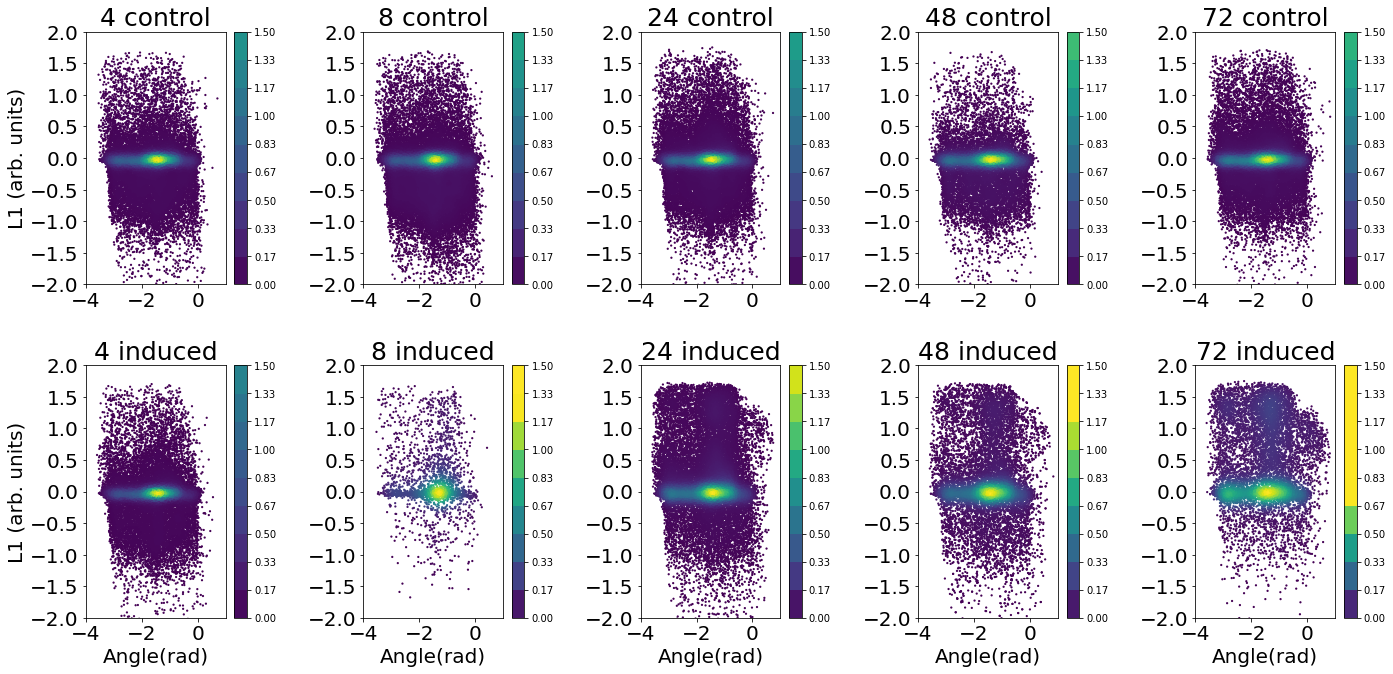

In [ ]:
#Control
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,5,1)
x = a4c[:,0]
y = a4c[:,3]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('4 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
ax.set_ylabel('L1 (arb. units)',fontsize=20)
ax.set_xlim([-4, 1])
ax.set_ylim([-2, 2])
# ax.set_clim(0,2)
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
# plt.clim(0,2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


ax = fig.add_subplot(2,5,2)
x = a8c[:,0]
y = a8c[:,3]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('8 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-4, 1])
ax.set_ylim([-2, 2])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,3)
x = a24c[:,0]
y = a24c[:,3]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('24 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-4, 1])
ax.set_ylim([-2, 2])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,4)
x = a48c[:,0]
y = a48c[:,3]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('48 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-4, 1])
ax.set_ylim([-2, 2])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,5)
x = a72c[:,0]
y = a72c[:,3]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('72 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-4, 1])
ax.set_ylim([-2, 2])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.tight_layout(pad=3.0)

#Induced
# fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,5,6)
x = a4i[:,0]
y = a4i[:,3]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('4 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('Angle(rad)',fontsize=20)
ax.set_ylabel('L1 (arb. units)',fontsize=20)
ax.set_xlim([-4, 1])
ax.set_ylim([-2, 2])
# ax.set_clim(0,2)
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
# plt.clim(0,2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


ax = fig.add_subplot(2,5,7)
x = a8i[:,0]
y = a8i[:,3]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('8 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-4, 1])
ax.set_ylim([-2, 2])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,8)
x = a24i[:,0]
y = a24i[:,3]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('24 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-4, 1])
ax.set_ylim([-2, 2])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,9)
x = a48i[:,0]
y = a48i[:,3]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('48 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-4, 1])
ax.set_ylim([-2, 2])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,10)
x = a72i[:,0]
y = a72i[:,3]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('72 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-4, 1])
ax.set_ylim([-2, 2])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.tight_layout(pad=3.0)

plt.savefig('all-L1vsAngle')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is depr

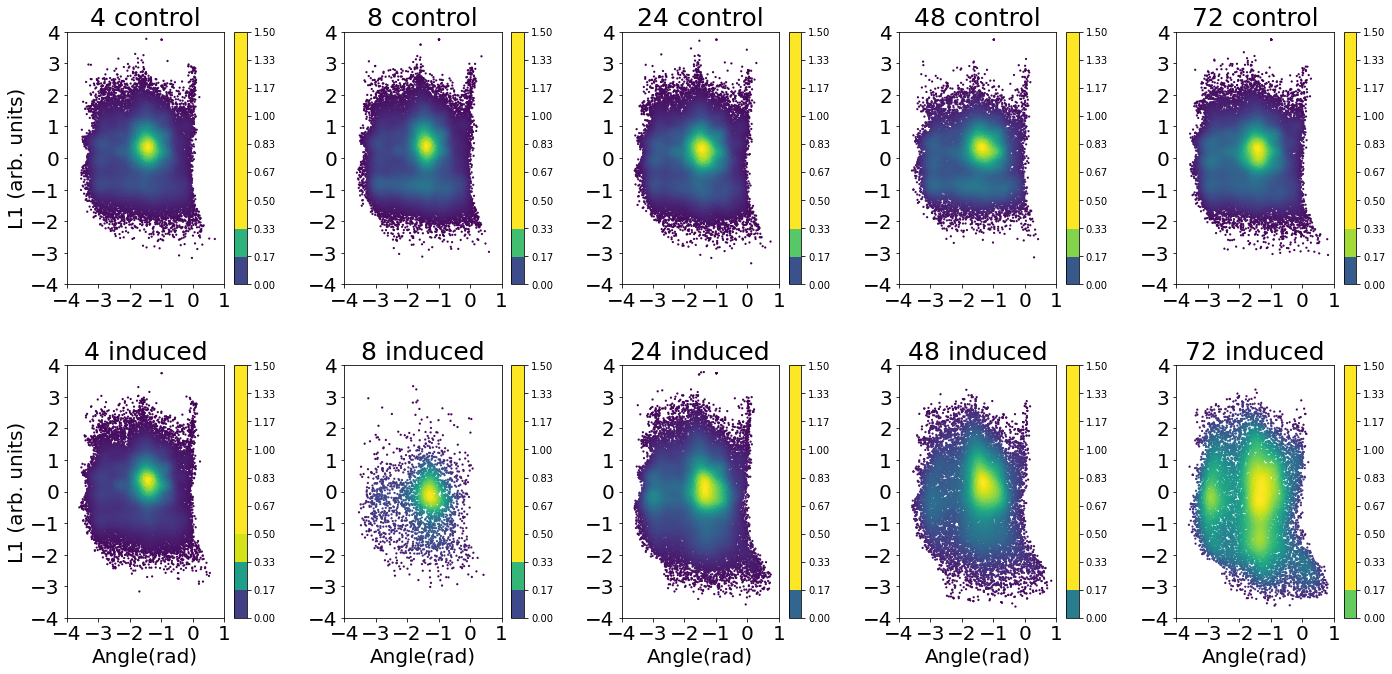

In [ ]:

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,5,1)
x = a4c[:,0]
y = a4c[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('4 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
ax.set_ylabel('L1 (arb. units)',fontsize=20)
ax.set_xlim([-4, 1])
ax.set_ylim([-4, 4])
# ax.set_clim(0,2)
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
# plt.clim(0,2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


ax = fig.add_subplot(2,5,2)
x = a8c[:,0]
y = a8c[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('8 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-4, 1])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,3)
x = a24c[:,0]
y = a24c[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('24 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-4, 1])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,4)
x = a48c[:,0]
y = a48c[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('48 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-4, 1])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,5)
x = a72c[:,0]
y = a72c[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('72 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-4, 1])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.tight_layout(pad=3.0)

#Induced
# fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,5,6)
x = a4i[:,0]
y = a4i[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('4 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('Angle(rad)',fontsize=20)
ax.set_ylabel('L1 (arb. units)',fontsize=20)
ax.set_xlim([-4, 1])
ax.set_ylim([-4, 4])
# ax.set_clim(0,2)
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
# plt.clim(0,2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


ax = fig.add_subplot(2,5,7)
x = a8i[:,0]
y = a8i[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('8 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-4, 1])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,8)
x = a24i[:,0]
y = a24i[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('24 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-4, 1])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,9)
x = a48i[:,0]
y = a48i[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('48 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-4, 1])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,10)
x = a72i[:,0]
y = a72i[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('72 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-4, 1])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.tight_layout(pad=3.0)

plt.savefig('all-L2vsAngle')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is depr

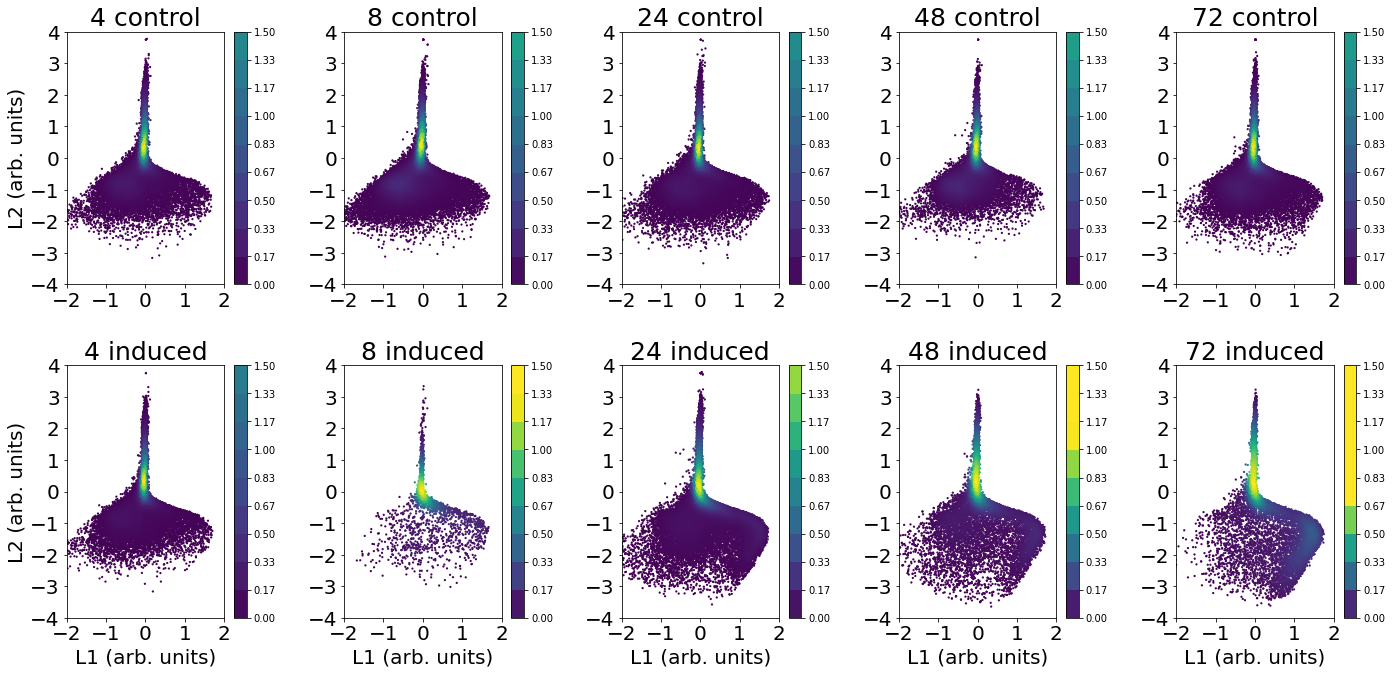

In [ ]:
#Control
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,5,1)
x = a4c[:,3]
y = a4c[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('4 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
ax.set_ylabel('L2 (arb. units)',fontsize=20)
ax.set_xlim([-2, 2])
ax.set_ylim([-4, 4])
# ax.set_clim(0,2)
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
# plt.clim(0,2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


ax = fig.add_subplot(2,5,2)
x = a8c[:,3]
y = a8c[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('8 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-2, 2])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,3)
x = a24c[:,3]
y = a24c[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('24 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-2, 2])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,4)
x = a48c[:,3]
y = a48c[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('48 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-2, 2])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,5)
x = a72c[:,3]
y = a72c[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('72 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-2, 2])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.tight_layout(pad=3.0)

#Induced
# fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,5,6)
x = a4i[:,3]
y = a4i[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('4 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('L1 (arb. units)',fontsize=20)
ax.set_ylabel('L2 (arb. units)',fontsize=20)
ax.set_xlim([-2, 2])
ax.set_ylim([-4, 4])
# ax.set_clim(0,2)
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
# plt.clim(0,2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


ax = fig.add_subplot(2,5,7)
x = a8i[:,3]
y = a8i[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('8 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('L1 (arb. units)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-2, 2])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,8)
x = a24i[:,3]
y = a24i[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('24 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('L1 (arb. units)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-2, 2])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,9)
x = a48i[:,3]
y = a48i[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('48 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('L1 (arb. units)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-2, 2])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,10)
x = a72i[:,3]
y = a72i[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('72 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('L1 (arb. units)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-2, 2])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.tight_layout(pad=3.0)

plt.savefig('all-L2vsL1')

1.7389133 -0.5
1.7389133 -1.0
1.7389133 -2.0
1.7389133 -2.5


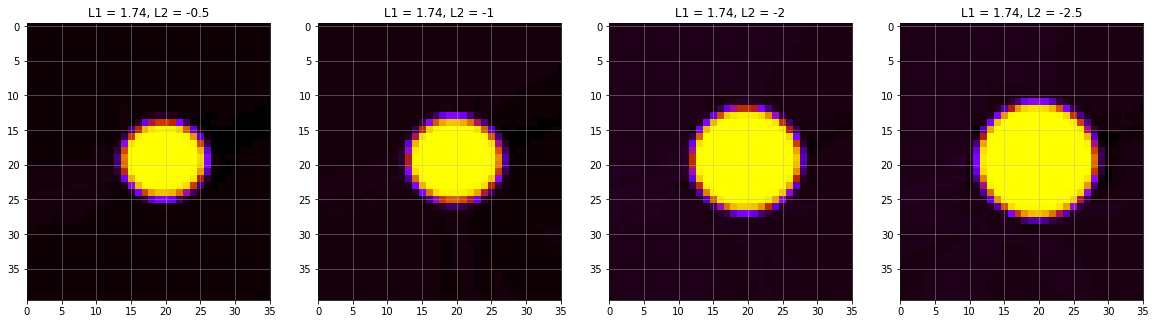

In [ ]:
lv1_vals = a72i[:,3][a72i[:,3] > 1.72]

# L2 = -0.5
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = -0.5 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded1 = rvae.decode(lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L2 = -1
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = -1 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded2 = rvae.decode(lv_vals)
# print("2",lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L2 = -2
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = -2 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded3 = rvae.decode(lv_vals)
# print(lv_vals)
# print("3",lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L2 = -2.5
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = -2.5 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded4 = rvae.decode(lv_vals)
# print("4",lv_vals)
print(lv1_vals[0],lv2_vals[0])

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,4,1)
ax.imshow(decoded1[0], cmap="gnuplot")
ax.set_title('L1 = 1.74, L2 = -0.5')
ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1,4,2)
ax.imshow(decoded2[0], cmap="gnuplot")
ax.set_title('L1 = 1.74, L2 = -1')
ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1,4,3)
ax.imshow(decoded3[0], cmap="gnuplot")
ax.set_title('L1 = 1.74, L2 = -2')

ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1,4,4)
ax.imshow(decoded4[0], cmap="gnuplot")
ax.set_title('L1 = 1.74, L2 = -2.5')
ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

plt.savefig('decoded-72induced')


0.0 -0.5
0.0 -1.0
0.0 -2.0
0.0 -2.5


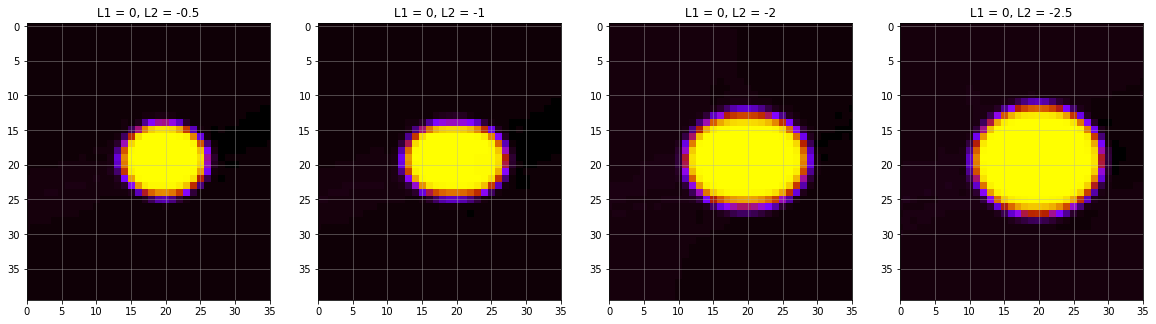

In [ ]:
lv1_vals = np.linspace(0.,1.6,1)

# L2 = -0.5
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = -0.5 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded1 = rvae.decode(lv_vals)
# print("1",lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L2 = -1
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = -1 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded2 = rvae.decode(lv_vals)
# print("2",lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L2 = -2
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = -2 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded3 = rvae.decode(lv_vals)
# print(lv_vals)
# print("3",lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L2 = -2.5
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = -2.5 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded4 = rvae.decode(lv_vals)
# print("4",lv_vals)
print(lv1_vals[0],lv2_vals[0])

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,4,1)
ax.imshow(decoded1[0], cmap="gnuplot")
ax.set_title('L1 = 0, L2 = -0.5')
ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1,4,2)
ax.imshow(decoded2[0], cmap="gnuplot")
ax.set_title('L1 = 0, L2 = -1')
ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1,4,3)
ax.imshow(decoded3[0], cmap="gnuplot")
ax.set_title('L1 = 0, L2 = -2')

ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1,4,4)
ax.imshow(decoded4[0], cmap="gnuplot")
ax.set_title('L1 = 0, L2 = -2.5')
ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

plt.savefig('decoded-72induced')


1.0 -0.5
1.0 -1.0
1.0 -2.0
1.0 -2.5


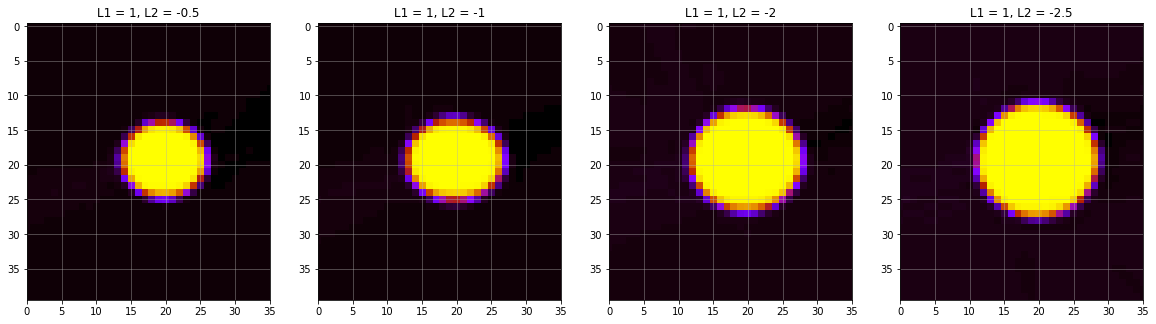

In [ ]:
lv1_vals = np.linspace(1.,1.6,1)

# L2 = -0.5
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = -0.5 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded1 = rvae.decode(lv_vals)
# print("1",lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L2 = -1
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = -1 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded2 = rvae.decode(lv_vals)
# print("2",lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L2 = -2
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = -2 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded3 = rvae.decode(lv_vals)
# print(lv_vals)
# print("3",lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L2 = -2.5
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = -2.5 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded4 = rvae.decode(lv_vals)
# print("4",lv_vals)
print(lv1_vals[0],lv2_vals[0])

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,4,1)
ax.imshow(decoded1[0], cmap="gnuplot")
ax.set_title('L1 = 1, L2 = -0.5')
ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1,4,2)
ax.imshow(decoded2[0], cmap="gnuplot")
ax.set_title('L1 = 1, L2 = -1')
ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1,4,3)
ax.imshow(decoded3[0], cmap="gnuplot")
ax.set_title('L1 = 1, L2 = -2')

ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1,4,4)
ax.imshow(decoded4[0], cmap="gnuplot")
ax.set_title('L1 = 1, L2 = -2.5')
ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

plt.savefig('decoded-72induced')

5 -0.00022782385 0.0
5 -0.00022782385 0.0
241 -2.0194826 0.0


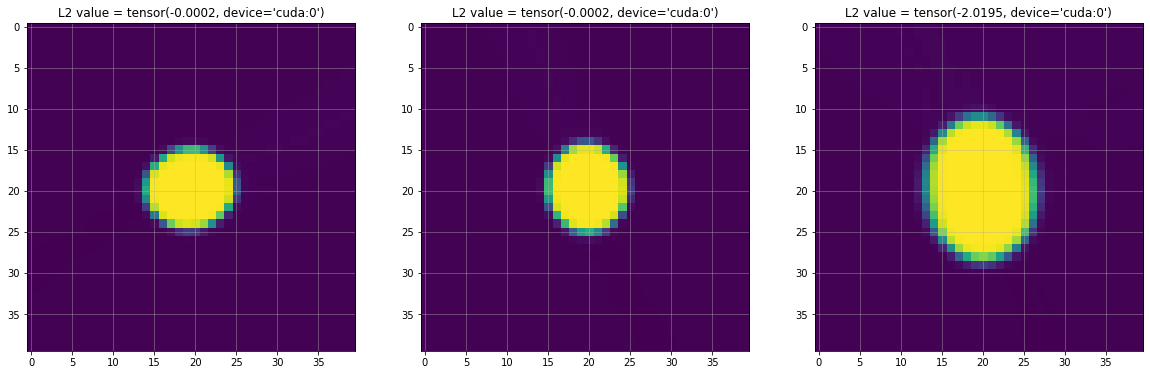

In [ ]:
import torch


#Fixing l1, and varying l2 and the angle
# l2 = 0, angle = -3
alpha = -3  
lv2_vals = a72i[:,4][(a72i[:,4] > -0.001) & (a72i[:,4] < 0)]
lv1_vals = np.zeros_like(lv2_vals) + 0

#Fixing L1 to zero and changing L2 and angle
arr_size = lv2_vals.size
print(arr_size,lv2_vals[0],lv1_vals[0])

device = rvae.device  # to ensure that our arrays are on the same device as model weights
grid = rvae.x_coord.expand(arr_size, *rvae.x_coord.size()).to(device)  # coordinate grid

# angle to rotate (if keeping it constant)
# alpha = -3  
a = (torch.ones(size=(arr_size,)) * alpha).to(device)
l2_1 = torch.from_numpy(lv2_vals).to(device)
l1_1 = torch.from_numpy(lv1_vals).to(device)

# Prepare inputs into the decoder
z = torch.cat((l1_1[:, None], l2_1[:, None]), dim=-1)
grid_ = aoi.utils.transform_coordinates(grid, a, 0)

# Decode
with torch.no_grad():
    decoded1 = rvae.decoder_net(grid_, z).cpu()


# l2 = 0, angle = -1.5
alpha = -1.5
lv2_vals = a72i[:,4][(a72i[:,4] > -0.001) & (a72i[:,4] < 0)]
lv1_vals = np.zeros_like(lv2_vals) + 0

#Fixing L1 to zero and changing L2 and angle
arr_size = lv2_vals.size
print(arr_size,lv2_vals[0],lv1_vals[0])

device = rvae.device  # to ensure that our arrays are on the same device as model weights
grid = rvae.x_coord.expand(arr_size, *rvae.x_coord.size()).to(device)  # coordinate grid

# angle to rotate (if keeping it constant) 
a = (torch.ones(size=(arr_size,)) * alpha).to(device)
l2_2 = torch.from_numpy(lv2_vals).to(device)
l1_2 = torch.from_numpy(lv1_vals).to(device)

# Prepare inputs into the decoder
z = torch.cat((l1_2[:, None], l2_2[:, None]), dim=-1)
grid_ = aoi.utils.transform_coordinates(grid, a, 0)

# Decode
with torch.no_grad():
    decoded2 = rvae.decoder_net(grid_, z).cpu()

# l2 = -2, angle = -1.5
alpha = -1.5  
lv2_vals = a72i[:,4][(a72i[:,4] > -2.1) & (a72i[:,4] < -2)]
lv1_vals = np.zeros_like(lv2_vals) + 0

#Fixing L1 to zero and changing L2 and angle
arr_size = lv2_vals.size
print(arr_size,lv2_vals[0],lv1_vals[0])


device = rvae.device  # to ensure that our arrays are on the same device as model weights
grid = rvae.x_coord.expand(arr_size, *rvae.x_coord.size()).to(device)  # coordinate grid

# angle to rotate (if keeping it constant)
# alpha = -3  
a = (torch.ones(size=(arr_size,)) * alpha).to(device)
l2_3 = torch.from_numpy(lv2_vals).to(device)
l1_3 = torch.from_numpy(lv1_vals).to(device)

# Prepare inputs into the decoder
z = torch.cat((l1_3[:, None], l2_3[:, None]), dim=-1)
grid_ = aoi.utils.transform_coordinates(grid, a, 0)

# Decode
with torch.no_grad():
    decoded3 = rvae.decoder_net(grid_, z).cpu()

fig = plt.figure( figsize=(20, 10))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(decoded1[0])
ax.set_title('L2 value = ' + str(l2_1[0]))
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1, 3, 2)
ax.imshow(decoded2[0])
ax.set_title('L2 value = ' + str(l2_2[0]))
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1, 3, 3)
ax.imshow(decoded3[0])
ax.set_title('L2 value = ' + str(l2_3[0]))
ax.grid(alpha = 0.5)
plt.savefig('angle-decoded-72induced')
